# Algorithmic methods for data mining - Homework 3 - Group #14

| Group Member      | Student ID  | Istitutional Email                   |
| ----------------- | ----------- | -------------------------------------|
| Aur Marina Iuliana        | 1809715     | aur.1809715@studenti.uniroma1.it     |
| Di Nino Leonardo  | 1919479     | dinino.1919479@studenti.uniroma1.it  |
| Fabri Luca        | 1892765     | fabri.1892765@studenti.uniroma1.it   |

First of all we want to import all the libraries that can be helpful in this homework. 

In [1]:
import pandas as pd                                            #DataScience Starter Pack
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import random                                                  #Pinch of simulation taste 

from itertools import combinations                             #Useful tools of the trade
from functools import reduce
from collections import Counter

import os                                                      #Needed to move between OS folders

import re

from bs4 import BeautifulSoup                                  #Scraper 
import requests                                                #URL drainer

from tqdm import tqdm

from datetime import datetime                                  #To be leveraged to define datetime objects  


import nltk                                                    #Text processing library
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


import locationtagger                                          #Useful map visualization tools
import plotly.express as px
import dash
from dash import dcc 

from sklearn.neighbors import KNeighborsClassifier             #Some ML aftertaste 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer    #Useful already implemented tfidf vectorizer from scikit learn library

import heapq                                                   #Library with useful methods to define heap data structures

import spacy

import time                                                    


Then we are going to import the .py modules we built to store all the defined methods and function, in order to be more tidy and use the notebook as a showcase for our results. We prefer to store the functions in separated files to be also expressive when calling a function and not to result caothic just in a different document!

In [2]:
import scraper as scraper
import engine as engine

# 1. Data collection

## 1.1. Get the list of places


First of all we had to gather all the links in the first 400 pages of Atlas Obscura's places sorted by popularity. We can just loop through the pages and combine *requests* and *BeautifulSoup* to store the 7200 gathered links in a .txt document that we will use in the next step to download the actual HTML.

In [ ]:
places = []

for i in range(1,401):
    main_url = 'https://www.atlasobscura.com/places?page=' + str(i) +'&sort=likes_count'
    cont = requests.get(main_url)
    soup = BeautifulSoup(cont.text)
    for place in soup.find_all('a', {'class':'content-card content-card-place'}):
        places.append('https://www.atlasobscura.com'+place.get('href'))

f = open('places.txt','w+')

for place in places:
    f.write(place+'\n')

f.close()

_____________

## 1.2 Crawl places

Then we locally built the folders to store the HTML documents using the *places.txt* document previously built. 

In [ ]:
f = open('places.txt','r')

lines = f.readlines()

dic = {}
for i in range(0,7200,18):
    dic[1+i//18] = lines[i:i+18]

for page in range(0,401):
    try:
        os.mkdir('ADM_HW3\\page ' + str(page))
    except FileExistsError:
        pass
    
    path = 'ADM_HW3\\page ' + str(page)
    os.chdir(path)

    for place in dic[page]:
        place_name = place[36:len(place)-1]
        vanilla = requests.get(place[:-1],allow_redirects=False,headers = {'User-agent': 'your bot 0.1'})
        
        with open(place_name+".txt",'w+',encoding="utf-8") as new_file:
            new_file.write(vanilla.text)

os.chdir('ADM_HW3')

____________

## 1.3 Parse downloaded pages

We needed to define a script to extract useful information from each HTML we collected. In particular we want these information:
1. Place Name (to save as $placeName$): String.
2. Place Tags (to save as $placeTags$): List of Strings.
3. Number of people who have been there (to save as $numPeopleVisited$): Integer.
4. Number of people who want to visit the place(to save as $numPeopleWant$): Integer.
5. Description (to save as $placeDesc$): String. Everything from under the first image up to "know before you go" (orange frame on the example image).
6. Short Description (to save as $placeShortDesc$): String. Everything from the title and location up to the image (blue frame on the example image).
7. Nearby Places (to save as $placeNearby$): Extract the names of all nearby places, but only keep unique values: List of Strings.
8. Address of the place(to save as $placeAddress$): String.
9. Altitude and Longitude of the place's location(to save as $placeAlt$ and $placeLong$): Integers
10. The username of the post editors (to save as $placeEditors$): List of Strings.
11. Post publishing date (to save as $placePubDate$): datetime.
12. The names of the lists that the place was included in (to save as $placeRelatedLists$): List of Strings.
13. The names of the related places (to save as $placeRelatedPlaces$): List of Strings.
14. The URL of the page of the place (to save as $placeURL$):String

We leverage *BeautifulSoup library* to scrape the information, but we need just an additional method to convert into a datetime object the post publishing date since it was a string in the format 'Month Day, Year'. For example we found 'May 8, 2010' for the very first link, and instead we wanted '2010/05/08'. This method does so:

In [3]:
scraper.string_to_datetime('May 8, 2010')

'2010-05-08'

We defined a **darkAtlasScraper** function that is stored in *scraper.py* module. This function builds a dictionary of information for every place we go through: then from this dictionary we'll build a .tsv for every HTML document we gathered.

Then we had  to define the script that goes through each folder and for each folder goes through each downloaded HTML, scrapes information and store them in a new .tsv file.

In [ ]:
for page in range(1,401):
    path = 'ADM_HW3\\page ' + str(page)
    os.chdir(path)
    
    for filename in os.listdir(os.getcwd()):
        os.chdir('ADM_HW3\\page ' + str(page))
        
        new_path = 'ADM_HW3\\page ' + str(page) + '\\' + filename
        soupper = open(new_path, 'r',encoding="utf-8")
        
        os.chdir('ADM_HW3\\tsv')
        newer_path = 'ADM_HW3\\tsv\\'+filename[:-4]+'.tsv'
        try:
            infos = scraper.darkAtlasScraper(soupper,filename)
        except IndexError:
            print(newer_path)
        with open(newer_path,'w+',encoding="utf-8") as new_file:
            for info in infos.values():
                if type(info) == list:
                    for index in range(len(info)):
                        if index < len(info) - 1:
                            new_file.write(str(info[index])+ ', ')
                        elif index == len(info) - 1:
                            new_file.write(str(info[index]))
                    new_file.write('\t')
                else:
                    new_file.write(str(info))
                    new_file.write('\t')

We then decided to build a .csv to collect all the data and to make them always available in a practical format. 

In [ ]:
path= "ADM_HW3\tsv"
final_dataset = []
filenames = os.listdir(path)

for file in filenames:
    if file.endswith('tsv'):
        file_path = os.path.join(path,file)
        try:
            df = pd.read_csv(file_path, sep ="\t", header=None, quoting=3)
            final_dataset.append(df)
        except:
            print(file)
            pass
    
final_dataset = pd.concat(final_dataset)
final_dataset.to_csv('final_dataset.csv', index = False)

From now on we are going to work with this *final_dataset.csv* that contains all the scraped information over the 7200 pages.

In [3]:
mostPopularPlaces = scraper.open_dataset('stuff/final_dataset.csv')
mostPopularPlaces

placeName  \
0                                    109 East Palace    
1                                   145 Rue Lafayette   
2                                        17 Room Ruin   
3                               1890s Alien Gravesite   
4     University of Virginia’s Hidden Chemical Hearth   
...                                               ...   
7195                                   Zorthian Ranch   
7196                                   Zuccari Palace   
7197                              Zwack Unicum Museum   
7198                           The Zymoglyphic Museum   
7199         Zzyzx Mineral Springs and Healing Center   

                                              placeTags  numPeopleVisited  \
0           manhattan project, secret, nuclear, science               417   
1     urban planning, cities, transportation, archit...               163   
2     abandoned houses, native americans, abandoned,...               161   
3               aliens, graves, gravestones, cemeteries               248   
4             thomas jefferson, unesco, hidden, science               130   
...                                                 ...               ...   
7195  film locations, farms, outsider art, collectio...                75   
7196      castles, architectural oddities, architecture               428   
7197  food museums, food, museums and collections, m...               198   
7198  obscura day locations, wonder cabinets, wunder...               218   
7199  hoaxes and pseudoscience, places to stay, outs...               282   

      numPeopleWant                                          placeDesc  \
0               470  When you need to be dropped off at a top-secre...   
1               412  While walking down the street, you’d be forgiv...   
2              1442  Outside Bluff, Utah, a massive 100-foot-deep a...   
3              1189  While it receives no fanfare today, the small ...   
4               436  Nestled in the ground floor of a UNESCO World ...   
...             ...                                                ...   
7195            468  California’s Zorthian Ranch is a strange compe...   
7196           1347  In Rome there are thousands of churches, old b...   
7197            419  Sometimes referred to as the Hungarian nationa...   
7198           1978  The Zymoglyphic Museum houses the cabinet of c...   
7199           1022  Curtis Howe Springer was a self-proclaimed med...   

                                         placeShortDesc  \
0     This innocuous New Mexico storefront was once ...   
1     What looks like a normal building is really a ...   
2     A well-preserved Ancestral Puebloan ruin tucke...   
3     This small town Texas cemetery is said to be t...   
4     Hidden for 165 years inside a building designe...   
...                                                 ...   
7195  The cobbled together compound of a deceased ar...   
7196  Architectural monsters are devouring this pala...   
7197  Central Europe's largest collection of mini-bo...   
7198  Private collection of art inspired by cabinets...   
7199  A former utopian healing center created by a h...   

                                            placeNearby  \
0     Palace of the Governors, Spitz Clock, La Conqu...   
1     WWII Bunker Under Gare de l'Est, Le Louxor Pal...   
2     House on Fire Ruin, Forrest Gump Point, Four C...   
3     The Lost Arm of F. Stewart, Chef Point Bar & R...   
4     University of Virginia's Seven Society, The Ra...   
...                                                 ...   
7195  Cobb Estate , The Bunny Museum, Mountain View ...   
7196  Keats-Shelley Memorial House, Santa Maria dell...   
7197  Paul Street Boys Monument, Gömböc, Little Neme...   
7198  Lincoln Street Kayak & Canoe Museum, Morrison ...   
7199  Travelers Monument, World's Largest Thermomete...   

                                           placeAddress placeAlt  placeLong  \
0      109 East Palace  Santa Fe, New Mexico, 87

### *Just a small EDA: consistency of the dataset*

We just want to get familiar with the places that drains interest or that have actually been visited by the highest number of people.

In [4]:
mostPopularPlaces.sort_values(by=['numPeopleVisited'], ascending = False).head(5)

placeName  \
147              Alcatraz Island   
2631               The High Line   
5109             Sagrada Família   
4768  Prague Astronomical Clock    
1890                Faneuil Hall   

                                              placeTags  numPeopleVisited  \
147   al capone, crime museums, lighthouses, prisons...              6625   
2631                    railroads, parks, plants, ruins              6461   
5109  churches, sacred spaces, architectural odditie...              5901   
4768  astronomical clocks, amazing automata, astound...              5686   
1890               architectural oddities, architecture              5319   

      numPeopleWant                                          placeDesc  \
147            4000  Alcatraz, also referred to as “The Rock,” is r...   
2631           3452  For the latter years of the 20th century, aban...   
5109           2366  When the foundation stone of the Basílica i Te...   
4768           2299  The legend of the Astronomical Clock in the Ol...   
1890            490  When Faneuil Hall was built in 1742, the marke...   

                                         placeShortDesc  \
147   In all of the 29 years it was in operation, no...   
2631  Elevated freight railway turned wildly success...   
5109  Construction of Barcelona's iconic (but contro...   
4768  Macabre astrological automaton clock dating to...   
1890  A former waterfront market is now in the cente...   

                                            placeNearby  \
147   Musée Mécanique, Aquatic Park Tombstones, Mago...   
2631  The Jane Hotel, Pier 54: The Titanic's Arrival...   
5109  Sewers of Barcelona, Sant Pau Recinte Modernis...   
4768  Prague Meridian, Sex Machines Museum, Paternos...   
1890  Faneuil Hall Weathervane, AHAC Headquarters, C...   

                                           placeAddress placeAlt  placeLong  \
147    Alcatraz Island San Francisco, California, 94...  37.8267  -122.4230   
2631   Washington St &amp; Gansevoort St  New York, ...  40.7392   -74.0083   
5109     401 Carrer de la Marina Barcelona, 08013 Spain  41.4036     2.1744   
4768   Staromestske Namesti Old Town Hall Prague Cze...   50.087    14.4208   
1890   1 US 1 # 1 Boston, Massachusetts, 02109 Unite...    42.36   -71.0562   

                                           placeEditors placePubDate  \
147   chesaniebeam, kks523, agent 81, jules 1f6b22b6...   2011-03-06   
2631  hibbibi, esotericroots, dlc31723, knoxium, ala...   2009-07-04   
5109  Iveth Mercedes, elizbsmith, colosseumtoursmark...   2013-09-09   
4768  AbortionCrib, vasilisapremudra, jonko61, katie...   2013-06-30   
1890  Julius Spada, cait7911, Taterchips, Gavin, dav...   2011-08-23   

                                     placeRelatedPlaces  \
147   Napier Prison, Captain Joe Byrd Cemetery , Old...   
2631  Garden of Sweet Remembrance, Vale of Cashmere,...   
5109  Basilica di San Frances Musical Pillars, The L...   
4768  St. Mark's Clock Tower (Torre dell'Orologio), ...   
1890  The Japanese-Style House of Prospect Park Sout...   

                                      placeRelatedLists  \
147   The World's Top 100 Wonders in 2018, San Franc...   
2631  A 'No Regrets' Tour With One of Our Top Photo ...   
5109                                                NaN   
4768                                                NaN   
1890                                                NaN   

                                               placeURL  
147   https://www.atlasobscura.com/places/alcatraz-i...  
2631       https://www.atlasobscura.com/places/highline  
5109  https://www.atlasobscura.com/places/sagrada-fa...  
4768  https://www.atlasobscura.com/places/prague-ast...  
1890   https://www.atlasobscura.com/places/faneuil-hall

In [6]:
mostPopularPlaces.sort_values(by=['numPeopleWant'], ascending = False).head(5)

placeName                                          placeTags  \
1197    City Hall Station  subways, subterranean, infrastructure, subterr...   
2629    Highgate Cemetery  rivals week, vampires, hoaxes, occult, catacom...   
3340    Leadenhall Market                      markets, film locations, film   
6910       The Wave Organ  sea organ, aletrail, sounds, music, outsider a...   
1013  Catacombes de Paris  ossuaries, memento mori, catacombs and crypts,...   

      numPeopleVisited  numPeopleWant  \
1197              1826           8572   
2629              2616           8180   
3340              3133           7561   
6910              2427           7401   
1013              4442           7037   

                                              placeDesc  \
1197  The first New York City subway was built and o...   
2629  Opened in 1839, Highgate is one of London’s mo...   
3340  The ornate 19th-century painted roof and cobbl...   
6910  Located on a jetty in the San Francisco Bay, t...   
1013  In 2004, Parisian police were assigned to do a...   

                                         placeShortDesc  \
1197  A beautiful and abandoned New York subway stat...   
2629  London's creepiest cemetery was once the site ...   
3340  This ornate Victorian marketplace was the sett...   
6910     A huge musical instrument played by the ocean.   
1013  The vast, legendary catacombs hold secrets muc...   

                                            placeNearby  \
1197  African Burial Ground National Monument, Tunne...   
2629  World's Largest Potted Plant, Dick Whittington...   
3340  The Cornhill Devils , London's Original and Al...   
6910  Long Now Orrery, The Stern of the Brigantine G...   
1013  Sculptures de Décure, Arago Medallions, Jeanno...   

                                           placeAddress placeAlt  placeLong  \
1197   31 Centre St New York, New York, 10007 United...  40.7134   -74.0046   
2629   Swain's Lane, Highgate London, England, N6 Un...  51.5675    -0.1483   
3340               London, England, EC3V United Kingdom  51.5126    -0.0834   
6910   83 Marina Green Dr San Francisco, California,...  37.8085  -122.4401   
1013      1 Place Denfert-Rochereau Paris, 75014 France  48.8343     2.3322   

                                           placeEditors placePubDate  \
1197  charding407, fosterc827, Mike H, erjeffery, Al...   2010-05-08   
2629  thesecretcity, thedyerghoulhouse, juliapetrush...   2014-08-09   
3340  Julius Spada, Katecrimson, thesecretcity, jule...   2016-08-01   
6910  routt1111, wefiddleboy14, Saal333, Neighborhoo...   2008-11-21   
1013  marypippen, ramonrodz2212, mathewbrowne, Fred ...   2009-02-13   

                                     placeRelatedPlaces  \
1197  Crystal Palace Subway, Moscow Metro Stations, ...   
2629  Jewett City Vampires, Tomb of the Mather Famil...   
3340  Rivendell, Bagdad Cafe, Gare de la Ciotat, Drv...   
6910  Sea Organ, Silent Green Kulturquartier, St. Jo...   
1013  Ossario di San Martino, Leuk Charnel House, Sa...   

                                      placeRelatedLists  \
1197  30 Unexpected Places to Have a Joyful Adventur...   
2629  The World's Top 100 Wonders in 2018, London's ...   
3340  The Ultimate Guide to Stunning, Surprising, or...   
6910  Leonardo Nam's 16 Quirky Roadside Attractions ...   
1013  19 Catacombs Sure to Tingle Your Spine, The Wo...   

                                               placeURL  
1197  https://www.atlasobscura.com/places/city-hall-...  
2629  https://www.atlasobscura.com/places/highgate-c...  
3340  https://www.atlasobscura.com/places/leadenhall...  
6910     https://www.atlasobscura.com/places/wave-organ  
1013  https://www.atlasobscura.com/places/catacombes...

We now want to evaluate the consistency of what we have built. 

In [6]:
mostPopularPlaces.isnull().sum()

placeName                0
placeTags               34
numPeopleVisited         0
numPeopleWant            0
placeDesc                0
placeShortDesc           0
placeNearby              0
placeAddress             0
placeAlt                 0
placeLong                0
placeEditors           399
placePubDate             1
placeRelatedPlaces      34
placeRelatedLists     4445
placeURL                 0
dtype: int64

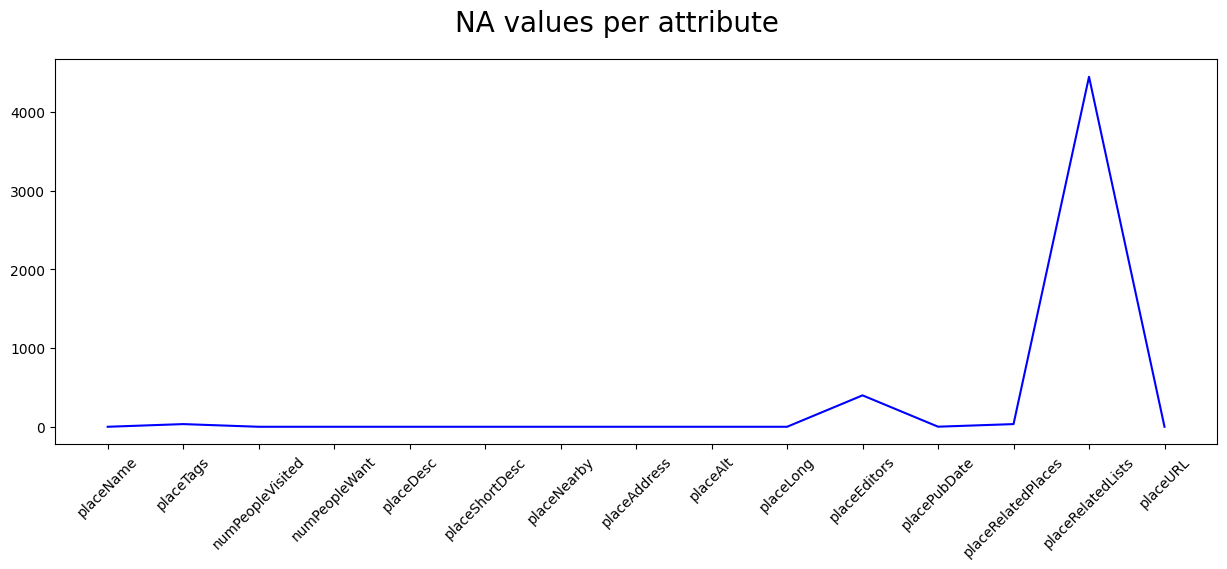

In [7]:
na_values = [mostPopularPlaces[column].isna().sum() for column in mostPopularPlaces.columns]

fig = plt.figure(figsize = (15,5))
fig.suptitle('NA values per attribute', fontsize = 20)

x = list(mostPopularPlaces.columns.values)
plt.plot(x, na_values, color = 'blue')
plt.xticks(rotation = 45)

plt.show()

As we can see the dataset we built is pretty consistent, except for some marginal information and a high percentace of lack in *placeRelatedLists* column. Let's just focus for a moment on the most missing value in the dataset.

In [10]:
mostPopularPlaces[mostPopularPlaces.placeRelatedLists.isna()].sort_values(by='numPeopleWant', ascending=False)

placeName  \
4018                               Museum of Death   
5253                          Seattle Underground    
4444                                       Oz Park   
6779                                 Venetian Pool   
4785                               President Heads   
...                                            ...   
3861               Monument to a Century of Flight   
5878                                     The Cairo   
4303                                 Obsidian Dome   
4297                                 Oakley Court    
5309  Shangri La Botanical Gardens & Nature Center   

                                              placeTags  numPeopleVisited  \
4018  suicide, oddities, skeletons, murder, taxiderm...              1030   
5253  subterranean, underground, subterranean sites,...              3446   
4444             film, outsider art, monuments, statues              1687   
6779  swimming pools, quarries, natural wonders, nature               751   
4785                     presidents, monuments, statues               449   
...                                                 ...               ...   
3861   flight, machines, aircraft, airplanes, monuments               535   
5878  law, government, urban planning, cities, archi...               342   
4303  hiking, volcanoes, mountains, natural wonders,...               149   
4297  pop culture, film locations, places to stay, h...                50   
5309                                                NaN                 0   

      numPeopleWant                                          placeDesc  \
4018           3543  From paintings by serial killers to shrunken h...   
5253           3473  In 1889, a fire raged through the fledgling ci...   
4444           3410  When the city of Chicago decided to improve th...   
6779           3382  The largest freshwater swimming pool in the U....   
4785           3297  What to do when you have dozens of 20-foot-tal...   
...             ...                                                ...   
3861            405  In a village in North Carolina’s Outer Banks, ...   
5878            405  Washington D.C.’s residential neighborhoods ar...   
4303            404  At the end of a dusty dirt road off California...   
4297            404  Now a luxury hotel, this is the place where “T...   
5309              2  “…I determined to gather together all things o...   

                                         placeShortDesc  \
4018  A collection of oddities including Dr. Kevorki...   
5253  A walk through the historic city center, under...   
4444  This whimsical Oz-themed park had a wonderful ...   
6779  The only swimming pool listed on the National ...   
4785  Giant busts of 42 U.S. presidents are sitting ...   
...                                                 ...   
3861  Down the road from where the Wright brothers l...   
5878  This unacceptably tall building was the real r...   
4303  A natural dome made of volcanic glass in Inyo ...   
4297  You can spend the night in Dr. Frank-N-Furter'...   
5309  Cradled in the midst of a southeast Texas town...   

                                            placeNearby  \
4018  Musical Legends Park, Jean Lafitte's Old Absin...   
5253  Ars Obscura, Smith Tower Penthouse, The Arctic...   
4444  Hudson Chess Park, Alinea Restaurant, The Wien...   
6779  The Kampong, Vizcaya Museum and Gardens, Miami...   
4785  Virginia Musical Museum, Lord Botetourt, Chown...   
...                                                 ...   
3861  Jockey's Ridge, Freedmen's Colony of Roanoke I...   
5878  Annie's Paramount Steakhouse, Charlotte Forten...   
4303  Devils Postpile National Monument, Mono Mills,...   
4297  Giant Royal Heads, The Queen's Swans at Windso...   
5309  Null Island, Cape Coast Castle, Black Star Square   

                                           placeAddress placeAlt  placeLong  \
4018   227 Dauphine St New Orleans, Louisiana, 70112...  29.9559   -90.0698   
52

The question we want to answer is wheter if the presence or the absence of this information is related to the number of people that actually visited the place or the number of people that want to visit it. It is interesting from a SEO perspective, since the *placeRelatedList* information enhances the performance of the page and should be a good way to spin it towards the interested people. Viceversa the lack in this information can be a cause or an effect of the lack of interest towards that specific place.

We plot this classification question with respect to our data.

<AxesSubplot:>

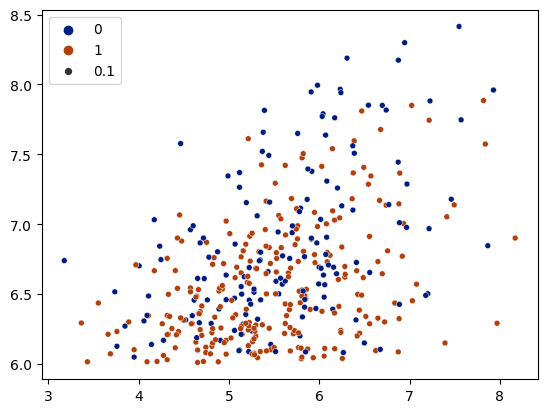

In [145]:
small_sample = random.sample(list(mostPopularPlaces.index), 400)

X1_sample = [math.log(mostPopularPlaces.iloc[idx].numPeopleVisited) for idx in small_sample if mostPopularPlaces.iloc[idx].numPeopleVisited > 0]
X2_sample = [math.log(mostPopularPlaces.iloc[idx].numPeopleWant) for idx in small_sample if mostPopularPlaces.iloc[idx].numPeopleWant > 0]
Y_test =  [int(mostPopularPlaces.placeRelatedLists.isna()[idx]) for idx in small_sample]

sns.scatterplot(x=X1_sample,y=X2_sample,hue=Y_test, size=0.1, palette='dark')

From a data visualization perspective there seems to be no interaction between these feature and our binary label of interest. In order to go deeper into our hypotesis we can use some tools from ML libraries to see how a classifier behaves if trained over this dataset. 

In [146]:
#Define a trainset and a testset (80/20)

train = random.sample(list(mostPopularPlaces.index), 5760)
test = [idx for idx in mostPopularPlaces.index if idx not in train]

X1_train = [mostPopularPlaces.iloc[idx].numPeopleVisited for idx in train]
X2_train = [mostPopularPlaces.iloc[idx].numPeopleWant for idx in train]

X1_test = [mostPopularPlaces.iloc[idx].numPeopleVisited for idx in test]
X2_test = [mostPopularPlaces.iloc[idx].numPeopleWant for idx in test]
Y_test =  [int(mostPopularPlaces.placeRelatedLists.isna()[idx]) for idx in test]

X_test = np.vstack((np.array(X1_test), np.array(X2_test))).T
Y_test = [int(mostPopularPlaces.placeRelatedLists.isna()[idx]) for idx in test]

X_train = np.vstack((np.array(X1_train), np.array(X2_train))).T
Y_train = [int(mostPopularPlaces.placeRelatedLists.isna()[idx]) for idx in train].reshape(-1,1)

In [ ]:
#Train the classifier 

classifier = KNeighborsClassifier(n_neighbors=10)    
classifier.fit(X_train, Y_train)
predictions = classifier.predict(X_test)           
score = metrics.roc_auc_score(Y_test, predictions)        

In [148]:
#Measure its behaviour

print('The AUROC score for a KNN Classifier is:', score)

The AUROC score for a KNN Classifier is: 0.5767779408069131


With such a value for AUROC our classifier behaves almost like a random classifier that is just unsystematically guessing, so we can't assert that there's a strong relation between the number of people interested or that actually visited a place and the presence of this place in some lists. So we can make other hypotesis about the reason between the high percentage of missing values in *placeRelatedLists* column, but as an explorative data analysis we can stop here.

We now just set a simple data cleaning in order to subsitute NaN values with empty strings as it was required.

In [7]:
mostPopularPlaces.placeTags.fillna('',inplace=True)
mostPopularPlaces.placeEditors.fillna('',inplace=True)   
mostPopularPlaces.placePubDate.fillna('',inplace=True)
mostPopularPlaces.placeRelatedPlaces.fillna('',inplace=True)
mostPopularPlaces.placeRelatedLists.fillna('',inplace=True)

We now have the whole dataset and we are ready to start building the search engines. 

_________________________________________________

## 2. Search Engine

We want to create several Search Engines that, given as input a query, return the places that match the query.

First, we must **pre-process** all the information collected for each place by:

1. Removing stopwords;
2. Removing punctuation;
3. Stemming.

For this purpose, we use the nltk library and build a specific function, **ntlk_analysis**, to retrieve tonekized documents: here's an example. 

In [5]:
engine.ntlk_analysis('an American Museum!')

['american', 'museum']

## 2.1. Conjunctive query

A conjunctive query is a query where the logical operator between every word of the query document is AND, so we want to match all the documents that contains all the word in the query. The basic search engine we are going to build will be essential to define also similarity-based search engine and to evaluate their performances.  

For the first version of the search engine, we narrow our interest to the **description** of each place. We create a new column in the dataframe, called *listOfWords*, where we put the pre-processed column field *placeDesc* passed as a parameter to the function described above.

In [5]:
listOfWords = []
for index in mostPopularPlaces['placeDesc'].index:
    description = mostPopularPlaces['placeDesc'][index]
    listOfWords.append(engine.ntlk_analysis(description)) 

In [6]:
mostPopularPlaces['listOfWords'] = listOfWords # initialization of the new column

In [7]:
mostPopularPlaces['listOfWords'].head(15) # a preview of the new column

0     [need, drop, research, facil, exist, address, ...
1     [walk, street, forgiven, think, parisian, buil...
2     [outsid, bluff, utah, massiv, alcov, loom, san...
3     [receiv, fanfar, today, small, town, aurora, t...
4     [nestl, ground, floor, unesco, world, heritag,...
5     [amidst, glut, shop, restaur, make, san, diego...
6     [loui, flight, cage, built, world, fair, year,...
7     [commerci, hub, excit, new, way, travel, art, ...
8     [home, futur, past, featur, aqua, tile, bathro...
9     [pope, john, paul, ii, gift, use, santi, vince...
10    [beeton, christma, annual, huge, popular, vict...
11    [updat, hour, church, elvi, longer, physic, lo...
12    [could, quit, possibl, frivol, yet, excit, adv...
13    [els, new, york, citi, would, find, stunningli...
14    [airplan, aficionado, rejoic, heaven, found, g...
Name: listOfWords, dtype: object

### 2.1.1) Create your index!

We need to build a vocabulary going through all the pre-processed documents: this is going to be the reference corpus for all the following implementations. We are going to use a dictionary as a data structure to simply map each of the unique words in the preprocessed documents to a progressive integer. Then we are going to store it in *vocabulary.txt* to make it always available.

In [7]:
vocabulary = {}
term_id = 1
words = []
for l in listOfWords:
    words += l
for word in sorted(list(set(words))):
    vocabulary[word] = term_id
    term_id += 1

This script creates the *vocabulary.txt* file.

In [11]:
with open('stuff/vocabulary.txt', 'w') as file:
    for word, term_id in vocabulary.items():
        file.write('%s:%s\n' % (word, term_id))

This one instead allows us to load the vocabulary from the file where it is stored.

In [8]:
vocabulary = engine.open_vocabulary('stuff/vocabulary.txt') # to load the file previously created

We now basically build the basic inverted index looping through all the preprocessed documents and storing each index related to term-ids to which we mapped each word in the previous phase. 

In [13]:
inverted_index = {}

for index, list_ in mostPopularPlaces['listOfWords'].iteritems():
    for word in set(list_):
        if vocabulary[word] in inverted_index:
            inverted_index[vocabulary[word]].append(index)
        else:
            inverted_index[vocabulary[word]] = [index]

This script creates the *inverted_index.txt* file.

In [14]:
inverted_index = dict(sorted(inverted_index.items()))
with open('stuff/inverted_index1.txt', 'w') as file:
    for word, indexing in inverted_index.items():
        texted_indexing = str(indexing[0]) + ', ' + ', '.join(list(map(str, indexing[1:])))
        file.write('%s:%s\n' % (word, texted_indexing))

This one makes it always available. 

In [9]:
inverted_index = engine.open_inverted_index('stuff/inverted_index1.txt') # to load the file previously created

### 2.1.2) Execute the query

We are now ready to build the first engine. We implemented the *search_match* function that is stored in **engine.py** module as a function that naively iterates through the inverted index and then performs intersection to actually express the result of a conjunctive query. 

The *visualize_result* function instead builds a new dataframe with the required information about the result of the query.

We are going to test three queries that are going to be the reference also for the more complex search engine that are going to come next.

##### *American museums*

In [10]:
# Find the common documents which contain the terms in the user's query
american_museums = engine.search_match('american museum', mostPopularPlaces, vocabulary, inverted_index)
# Visualize the result 
american_museums_matched = engine.visualize_result(mostPopularPlaces, american_museums)
american_museums_matched

placeName  \
1024                   Catoctin Furnace   
6657                              U-505   
1542    Diego Rivera's Detroit Industry   
1031                 Cave Hill Cemetery   
3593          Mansfield Memorial Museum   
...                                 ...   
1002                        Castle Post   
495               Belgrade Tesla Museum   
2548  Harvard Museum of Natural History   
3060                      KattenKabinet   
3574       Mammoth Cave Wildlife Museum   

                                              placeDesc  \
1024  In the early 1770s, Thomas Johnson discovered ...   
6657  One of only four remaining U-boats in the worl...   
1542  In a city overflowing with street art, murals,...   
1031  Holding the bodies of a number of influential ...   
3593  Back at the 1939 World’s Fair in New York, Ele...   
...                                                 ...   
1002  Looking more like an abandoned Medieval Times ...   
495   In the center of Belgrade, a villa holds the w...   
2548  Collecting three different institutions into o...   
3060  The death of a pet can inspire a number of rea...   
3574  Cave City is a wonderland of kitschy tourist t...   

                                               placeURL  
1024  https://www.atlasobscura.com/places/catoctin-f...  
6657          https://www.atlasobscura.com/places/u-505  
1542  https://www.atlasobscura.com/places/diego-rive...  
1031  https://www.atlasobscura.com/places/cave-hill-...  
3593  https://www.atlasobscura.com/places/mansfield-...  
...                                                 ...  
1002    https://www.atlasobscura.com/places/castle-post  
495   https://www.atlasobscura.com/places/belgrade-t...  
2548  https://www.atlasobscura.com/places/harvard-mu...  
3060  https://www.atlasobscura.com/places/kattenkabinet  
3574  https://www.atlasobscura.com/places/mammoth-ca...  

[239 rows x 3 columns]

##### *Ghost towns*

In [41]:
ghost_towns = engine.search_match('ghost towns', mostPopularPlaces, vocabulary, inverted_index)
ghost_towns_matched = engine.visualize_result(mostPopularPlaces, ghost_towns)
ghost_towns_matched

placeName  \
2563                 Haunted Vista   
6148              The Mizpah Hotel   
3082              Kelso Ghost Town   
5642               Studio Antiques   
3092          Kennicott Ghost Town   
...                            ...   
1003        Castle Town Ghost Town   
6638                  Turtle Mound   
2031  Fort Union National Monument   
6651                      Two Guns   
6143             Mine Shaft Tavern   

                                              placeDesc  \
2563  The Anna S. underground mine on Rattler Mounta...   
6148  Built in 1907 when the central Nevada town of ...   
3082  Now little more than a ghost village, Kelso De...   
5642  Studio Antiques is a veritable treasure trove ...   
3092  The town Kennicott in Alaska was once flourish...   
...                                                 ...   
1003  The ghost town of Castle is one of many towns ...   
6638  At over 50 feet tall, this shell midden is one...   
2031  A former bustling military fort that has lain ...   
6651  It has all the workings of a modern-day Hamlet...   
6143  In a town of about 204 residents, you might no...   

                                               placeURL  
2563  https://www.atlasobscura.com/places/haunted-vista  
6148  https://www.atlasobscura.com/places/the-mizpah...  
3082  https://www.atlasobscura.com/places/kelso-ghos...  
5642  https://www.atlasobscura.com/places/studio-ant...  
3092  https://www.atlasobscura.com/places/kennicott-...  
...                                                 ...  
1003  https://www.atlasobscura.com/places/castle-tow...  
6638   https://www.atlasobscura.com/places/turtle-mound  
2031  https://www.atlasobscura.com/places/fort-union...  
6651       https://www.atlasobscura.com/places/two-guns  
6143  https://www.atlasobscura.com/places/the-mine-s...  

[129 rows x 3 columns]

#### *Old churches*

In [12]:
old_church = engine.search_match('old church', mostPopularPlaces, vocabulary, inverted_index)
old_church_matched = engine.visualize_result(mostPopularPlaces, old_church)
old_church_matched

placeName  \
5632                        Strahov Monastery    
2050                     Fountain of Innocents   
11                     24 Hour Church of Elvis   
5143                  Salty Dog Pottery Studio   
6683     Underground Railroad Experience Trail   
...                                        ...   
1014  Catacombs of Old St. Patrick's Cathedral   
1019                   Cathedral of St. Joseph   
6652                     Two Princes Staircase   
3069                         Keen's Steakhouse   
1022                   Cathedral Peacock Hutch   

                                              placeDesc  \
5632  Tucked away on the top of a hill in Prague is ...   
2050  At first glance, Place Joachim-du-Bellay looks...   
11    Update: 24 hour church of elvis no longer has ...   
5143  The Salty Dog Pottery Studio formed in 1975 wi...   
6683  The town of Sandy Spring, Maryland was settled...   
...                                                 ...   
1014  The catacombs under the Old St. Patrick’s Cath...   
1019  In Western Hartford, on the opposite side of t...   
6652  In the White Tower, the old keep at the Tower ...   
3069  Located in a neighborhood that has changed all...   
1022  Locals who drop by the Cathedral Church of St....   

                                               placeURL  
5632  https://www.atlasobscura.com/places/strahov-mo...  
2050  https://www.atlasobscura.com/places/fountain-o...  
11    https://www.atlasobscura.com/places/24-hour-ch...  
5143  https://www.atlasobscura.com/places/salty-dog-...  
6683  https://www.atlasobscura.com/places/undergroun...  
...                                                 ...  
1014  https://www.atlasobscura.com/places/catacombs-...  
1019  https://www.atlasobscura.com/places/cathedral-...  
6652  https://www.atlasobscura.com/places/two-prince...  
3069  https://www.atlasobscura.com/places/keen-s-ste...  
1022  https://www.atlasobscura.com/places/cathedral-...  

[151 rows x 3 columns]

# 2.2. Conjunctive query & Ranking score

First of all we want to define the **inverse document frequency** vector, where we define weights for each $j_{th}$ word through the factor $log_{10}\frac{n}{n_j}$, where $n$ is the total number of documents and $n_j$ is the number of occurrencies of that word. After storing the occurrencies of each word in the vocabulary we just repeat similar procedures as we did previously. 

In [13]:
word_occ = Counter(reduce(lambda x,y:x+y, mostPopularPlaces.listOfWords))
idf = {}
for word in word_occ.keys():
    idf[word] = math.log10(7200/word_occ[word])

In [14]:
tfidf_inverted_index = {}

for index, list_ in mostPopularPlaces['listOfWords'].iteritems():
    counter = Counter(list_)
    for word in set(list_):
        tf_idf = counter[word]*idf[word]/len(list_)
        if vocabulary[word] in tfidf_inverted_index:
            tfidf_inverted_index[vocabulary[word]].append((index, tf_idf))
        else:
            tfidf_inverted_index[vocabulary[word]] = [(index, tf_idf)]

We store as usual this partial result in a .txt file, to make it always available.

In [14]:
tfidf_inverted_index = dict(sorted(tfidf_inverted_index.items()))
with open('stuff/tfidf_inverted_index.txt', 'w') as file:
    for word, indexing in tfidf_inverted_index.items():
        texted_indexing = str(indexing[0]) + ', ' + ', '.join(list(map(str, indexing[1:])))
        file.write('%s:%s\n' % (word, texted_indexing))

We now can finally see how our new engine works when sorting the results already gathered by the basic engine. The *tfdif_searc_match* function uses a heap structure to store the places with respect to their score, that is computed through a cosine similarity on the vectorized documents and the vectorized query, taking into account that this vectors are sparse so we can build them starting from the tfidf inverted index.

In [15]:
engine.tfidf_search_match('american museum', mostPopularPlaces, vocabulary, tfidf_inverted_index, idf, 10)

placeName  \
1145                               Chimney Rock   
1906  Felicity, California: Center of the World   
2329                           Governors Island   
2244                 Gillette Castle State Park   
1605                            Double Negative   
5678                   Susanna Dickinson Museum   
5810                         The Athenian Agora   
6569          Treasures of the Steamboat Arabia   
5147                                  SAM 26000   
363                              Awat'ovi Ruins   

                                              placeDesc  \
1145  Chimney Rock stands tall over the Oregon Trail...   
1906  According to the French government and Califor...   
2329  Governors Island has quite a lot of history to...   
2244  High above the Connecticut River, Gillette Cas...   
1605  “There is nothing there, yet it is still a scu...   
5678  According to a plaque outside her last survivi...   
5810  Lying right beneath the northern slope of the ...   
6569  When the mighty Steamboat Arabia sank near Kan...   
5147  Famous, powerful figures have criss-crossed th...   
363   On a windswept mesa overlooking the Hopi reser...   

                                               placeURL  cosineSimilarity  
1145   https://www.atlasobscura.com/places/chimney-rock               1.0  
1906  https://www.atlasobscura.com/places/felicity-c...               1.0  
2329  https://www.atlasobscura.com/places/governor-s...               1.0  
2244  https://www.atlasobscura.com/places/gillettes-...               1.0  
1605  https://www.atlasobscura.com/places/double-neg...               1.0  
5678  https://www.atlasobscura.com/places/susanna-di...               1.0  
5810  https://www.atlasobscura.com/places/the-atheni...               1.0  
6569  https://www.atlasobscura.com/places/treasures-...               1.0  
5147      https://www.atlasobscura.com/places/sam-26000               1.0  
363   https://www.atlasobscura.com/places/awatovi-ruins               1.0

In [16]:
engine.tfidf_search_match('ghost town', mostPopularPlaces, vocabulary, tfidf_inverted_index, idf, 10)

placeName  \
1251                       Coffin It Up   
4161                    Nebraska Bridge   
2456                  Gunkanjima Island   
5705                 T. A. Moulton Barn   
1391  Cryptozoology & Paranormal Museum   
43      Abandoned Chacaltaya Ski Resort   
783          Bube's Brewery & Catacombs   
570                 Big Mine Run Geyser   
2838                         Indian Key   
1337                         Couch Tomb   

                                              placeDesc  \
1251  Hidden in the outskirts of Pahrump, Nevada in ...   
4161  Unlike most bridges that are meant to stretch ...   
2456  Few places in the world have a history as odd,...   
5705  This rustic old barn, perfectly positioned bef...   
1391  The spookiest, most unexplainable phenomena al...   
43    The Chacaltaya Ski Resort was once the only sk...   
783   Sometimes in the course of human events, it be...   
570   Big Mine Run Geyser is the only geyser on the ...   
2838  Florida’s Indian Key is located a just north o...   
1337  Like many present-day green spaces, Chicago’s ...   

                                               placeURL  cosineSimilarity  
1251   https://www.atlasobscura.com/places/coffin-it-up               1.0  
4161  https://www.atlasobscura.com/places/nebraska-b...               1.0  
2456  https://www.atlasobscura.com/places/gubkanjima...               1.0  
5705  https://www.atlasobscura.com/places/t-a-moulto...               1.0  
1391  https://www.atlasobscura.com/places/cryptozool...               1.0  
43    https://www.atlasobscura.com/places/abandoned-...               1.0  
783   https://www.atlasobscura.com/places/bubes-brew...               1.0  
570   https://www.atlasobscura.com/places/big-mine-r...               1.0  
2838     https://www.atlasobscura.com/places/indian-key               1.0  
1337     https://www.atlasobscura.com/places/couch-tomb               1.0

In [17]:
engine.tfidf_search_match('old church', mostPopularPlaces, vocabulary, tfidf_inverted_index, idf, 10)

placeName  \
664                          Boleskine House   
552                       Beth Haim Cemetery   
2644                 Hirta Island Ghost Town   
2944                 Jeffrey City Ghost Town   
4841                 Pyramids of Tlatelolco    
2341                      Grafton Ghost Town   
1692                    Earnestine & Hazel's   
5984                      The Fortingall Yew   
6015                            Govan Stones   
5524  St. Catherine of Siena's Severed Head    

                                              placeDesc  \
664   Boleskine House has been an eerie spot basical...   
552   On the outskirts of Amsterdam lies the small t...   
2644  Though St Kilda had been inhabited for more th...   
2944  A once thriving uranium mining town, Jeffrey C...   
4841  In the Plaza de las Tres Culturas with its dis...   
2341  The so-called Dixie region of Utah was settled...   
1692  The Memphis lounge Earnestine and Hazel’s has ...   
5984  Some people claim Scotland’s Fortingall Yew is...   
6015  In the heart of the working-class Govan distri...   
5524  Set in an ornate reliquary in the Basilica San...   

                                               placeURL  cosineSimilarity  
664   https://www.atlasobscura.com/places/boleskine-...               1.0  
552   https://www.atlasobscura.com/places/beth-haim-...               1.0  
2644  https://www.atlasobscura.com/places/hirta-isla...               1.0  
2944  https://www.atlasobscura.com/places/jeffrey-ci...               1.0  
4841  https://www.atlasobscura.com/places/pyramids-o...               1.0  
2341  https://www.atlasobscura.com/places/grafton-gh...               1.0  
1692  https://www.atlasobscura.com/places/earnestine...               1.0  
5984  https://www.atlasobscura.com/places/the-fortin...               1.0  
6015  https://www.atlasobscura.com/places/the-govan-...               1.0  
5524  https://www.atlasobscura.com/places/st-dominic...               1.0

# 3. Define a new score!


From a qualitative perspective we decided to implement a jaccard similarity over the tags, in order to use another information. The documents are retrieved again as a result of a conjunctive query over their full description in order to make the results comparable. 

This measure over the tags should result in a more semantic measure than a syntactic one. Infact the tags as documents are way more concise and focused on the actual content of the description. By the way there's clearly a trade off between expressiveness and density of information, as we can see from the scores we get for example on the 'american museum' query.

The *new_score_jaccard* function computes this new score, leveraging heap structure to store the sorted values and using the definition of Jaccard similarity over the documents retrieved by the basic search engine. 

The *jaccard* function measures similarity between finite sample sets and is defined as the size of the intersection divided by the size of the union of the sample sets.

In [18]:
engine.new_score_jaccard('american museum', mostPopularPlaces, vocabulary, inverted_index, 10) 

placeName  \
1701  East Kong Yick Building at the Wing Luke Museum   
4142                     National World War II Museum   
4979                                   Rock Art Ranch   
3528                                 Lunch Box Museum   
3734                            Metropolitan Pit Stop   
3990                  Museum of the American Cocktail   
3807                       Mitsitam Native Foods Cafe   
2548                Harvard Museum of Natural History   
1636                                     Drayton Hall   
2791                      Hugh Mercer Apothecary Shop   

                                              placeDesc  \
1701  In 1910, 170 early Chinese pioneers pooled the...   
4142   Perhaps once thought too narrowly focused, th...   
4979  Rock Art Ranch, near Winslow, Arizona, is a pr...   
3528  Lunch boxes bring back a certain sense of nost...   
3734  Metropolitan Pit Stop was founded by Jimmy Val...   
3990  They say that New Orleans is the home of the f...   
3807  A visit to the National Mall in Washington, D....   
2548  Collecting three different institutions into o...   
1636  Considered one of the most beautiful examples ...   
2791  Hugh Mercer was a Scot, a warrior, a friend of...   

                                               placeURL  newScore  
1701  https://www.atlasobscura.com/places/east-kong-...  0.500000  
4142  https://www.atlasobscura.com/places/national-w...  0.333333  
4979  https://www.atlasobscura.com/places/rock-art-r...  0.333333  
3528  https://www.atlasobscura.com/places/lunch-box-...  0.333333  
3734  https://www.atlasobscura.com/places/metropolit...  0.333333  
3990  https://www.atlasobscura.com/places/museum-ame...  0.333333  
3807  https://www.atlasobscura.com/places/mitsitam-n...  0.333333  
2548  https://www.atlasobscura.com/places/harvard-mu...  0.333333  
1636   https://www.atlasobscura.com/places/drayton-hall  0.285714  
2791  https://www.atlasobscura.com/places/hugh-merce...  0.285714

### *Comparing results*

In order to quantitative evaluate the performance of this two similarity scores we should be able to retrieve the relevant matches. This is a hard task to acomplish, since it implies advanced tools about natural language processing. The framework would be this: 
- Consider all the retrieved documents as the sample space;
- Consider all the relevant documents as positive cases, the not-relevant as negative cases;
- Setting thresholds and shifting them, we would have stored the behaviour of the scores in choosing wheter if a retrieved document is relevant or not;
- We would have build the receiver-operator characteristic curve for each score on each query and consider the area under each of these curves as a good indicator of the behaviour of the engine.

We can actually focus on the 'american museums' query as a good example to retrieve also the relevant documents. We may assert that a retrieved document is also relevant if it satisfies one or more conditions:
- It's address is actually located in the United States;
- It's short description also matches with the query;
- It's name contains at least one of the words of the query;
- ...

We are considering a simple condition to establish whether if a document is relevant or not: it is relevant if its *placeName* contains the word 'museum'. 

So now we are going to build dataframes where we have all the scores for all the retrieved documents.

In [19]:
k1 = len(american_museums_matched)

american_tfdif = engine.tfidf_search_match('american museum', mostPopularPlaces, vocabulary, tfidf_inverted_index, idf, k1)
american_jaccard = engine.new_score_jaccard('american museum', mostPopularPlaces, vocabulary, inverted_index, k1) 

american_museum_results = american_jaccard.merge(american_tfdif)
american_museum_results

placeName  \
0    East Kong Yick Building at the Wing Luke Museum   
1                       National World War II Museum   
2                                     Rock Art Ranch   
3                                   Lunch Box Museum   
4                              Metropolitan Pit Stop   
..                                               ...   
234                                     Peden's Cave   
235                            Truth or Consequences   
236                           V. C. Morris Gift Shop   
237                                    French Azilum   
238                              Indian Steps Museum   

                                             placeDesc  \
0    In 1910, 170 early Chinese pioneers pooled the...   
1     Perhaps once thought too narrowly focused, th...   
2    Rock Art Ranch, near Winslow, Arizona, is a pr...   
3    Lunch boxes bring back a certain sense of nost...   
4    Metropolitan Pit Stop was founded by Jimmy Val...   
..                                                 ...   
234  Found at the top of a red stone cliff overlook...   
235  Located along the Rio Grande in middle of the ...   
236  This building, on Maiden Lane in downtown San ...   
237  Despite France’s crucial role in helping Ameri...   
238  Constructed by a local lawyer from 1908-1912, ...   

                                              placeURL  newScore  \
0    https://www.atlasobscura.com/places/east-kong-...  0.500000   
1    https://www.atlasobscura.com/places/national-w...  0.333333   
2    https://www.atlasobscura.com/places/rock-art-r...  0.333333   
3    https://www.atlasobscura.com/places/lunch-box-...  0.333333   
4    https://www.atlasobscura.com/places/metropolit...  0.333333   
..                                                 ...       ...   
234    https://www.atlasobscura.com/places/pedens-cave  0.000000   
235  https://www.atlasobscura.com/places/truth-or-c...  0.000000   
236  https://www.atlasobscura.com/places/v-c-morris...  0.000000   
237  https://www.atlasobscura.com/places/french-azilum  0.000000   
238  https://www.atlasobscura.com/places/indian-ste... -1.000000   

     cosineSimilarity  
0            0.964938  
1            0.629293  
2            0.987851  
3            0.964938  
4            0.964938  
..                ...  
234          1.000000  
235          0.987851  
236          1.000000  
237          1.000000  
238          0.997075  

[239 rows x 5 columns]

In [69]:
relevant_retrieved = american_museum_results[american_museum_results.placeName.str.contains('Museum')]
relevant_retrieved

placeName  \
0    East Kong Yick Building at the Wing Luke Museum   
1                       National World War II Museum   
3                                   Lunch Box Museum   
5                    Museum of the American Cocktail   
7                  Harvard Museum of Natural History   
..                                               ...   
185                 National Watch and Clock Museum    
203                        Museum of Russian Culture   
207                                   Pianola Museum   
219                      The American Pigeon Museum    
238                              Indian Steps Museum   

                                             placeDesc  \
0    In 1910, 170 early Chinese pioneers pooled the...   
1     Perhaps once thought too narrowly focused, th...   
3    Lunch boxes bring back a certain sense of nost...   
5    They say that New Orleans is the home of the f...   
7    Collecting three different institutions into o...   
..                                                 ...   
185  In our age, state-of-the-art clocks keep time ...   
203  When you think San Francisco, you probably don...   
207  In a city chock-a-block with museums, one of t...   
219  Many people, especially in big cities, view pi...   
238  Constructed by a local lawyer from 1908-1912, ...   

                                              placeURL  newScore  \
0    https://www.atlasobscura.com/places/east-kong-...  0.500000   
1    https://www.atlasobscura.com/places/national-w...  0.333333   
3    https://www.atlasobscura.com/places/lunch-box-...  0.333333   
5    https://www.atlasobscura.com/places/museum-ame...  0.333333   
7    https://www.atlasobscura.com/places/harvard-mu...  0.333333   
..                                                 ...       ...   
185  https://www.atlasobscura.com/places/national-w...  0.000000   
203  https://www.atlasobscura.com/places/museum-of-...  0.000000   
207  https://www.atlasobscura.com/places/pianola-mu...  0.000000   
219  https://www.atlasobscura.com/places/the-americ...  0.000000   
238  https://www.atlasobscura.com/places/indian-ste... -1.000000   

     cosineSimilarity  relevance  
0            0.964938        1.0  
1            0.629293        1.0  
3            0.964938        1.0  
5            0.857904        1.0  
7            0.575413        1.0  
..                ...        ...  
185          0.964938        1.0  
203          0.759636        1.0  
207          0.822614        1.0  
219          0.964938        1.0  
238          0.997075        1.0  

[108 rows x 6 columns]

In [21]:
relevant_index = np.zeros(k1)
for ind in american_museum_results.index:
    if ind in relevant_retrieved.index:
        relevant_index[ind] = 1

In [22]:
american_museum_results['relevance'] = relevant_index

In [23]:
american_museum_results.head(10)

placeName  \
0  East Kong Yick Building at the Wing Luke Museum   
1                     National World War II Museum   
2                                   Rock Art Ranch   
3                                 Lunch Box Museum   
4                            Metropolitan Pit Stop   
5                  Museum of the American Cocktail   
6                       Mitsitam Native Foods Cafe   
7                Harvard Museum of Natural History   
8                                     Drayton Hall   
9                      Hugh Mercer Apothecary Shop   

                                           placeDesc  \
0  In 1910, 170 early Chinese pioneers pooled the...   
1   Perhaps once thought too narrowly focused, th...   
2  Rock Art Ranch, near Winslow, Arizona, is a pr...   
3  Lunch boxes bring back a certain sense of nost...   
4  Metropolitan Pit Stop was founded by Jimmy Val...   
5  They say that New Orleans is the home of the f...   
6  A visit to the National Mall in Washington, D....   
7  Collecting three different institutions into o...   
8  Considered one of the most beautiful examples ...   
9  Hugh Mercer was a Scot, a warrior, a friend of...   

                                            placeURL  newScore  \
0  https://www.atlasobscura.com/places/east-kong-...  0.500000   
1  https://www.atlasobscura.com/places/national-w...  0.333333   
2  https://www.atlasobscura.com/places/rock-art-r...  0.333333   
3  https://www.atlasobscura.com/places/lunch-box-...  0.333333   
4  https://www.atlasobscura.com/places/metropolit...  0.333333   
5  https://www.atlasobscura.com/places/museum-ame...  0.333333   
6  https://www.atlasobscura.com/places/mitsitam-n...  0.333333   
7  https://www.atlasobscura.com/places/harvard-mu...  0.333333   
8   https://www.atlasobscura.com/places/drayton-hall  0.285714   
9  https://www.atlasobscura.com/places/hugh-merce...  0.285714   

   cosineSimilarity  relevance  
0          0.964938        1.0  
1          0.629293        1.0  
2          0.987851        0.0  
3          0.964938        1.0  
4          0.964938        0.0  
5          0.857904        1.0  
6          1.000000        0.0  
7          0.575413        1.0  
8          0.987851        0.0  
9          0.964938        0.0

Now we can set different thresholds and store the different confusion-matrix scores of the two classifiers. 

##### ***Cosine-similarity on TFIDF: performance evaluation***

In [24]:
thresholds = np.linspace(0,1,21)
TP = []
TN = []
FP = []
FN = []

Accuracy = []
Precision = []
Recall = []
F = []
for t in np.flip(thresholds):
    predictions = np.array([0 if y < t else 1 for y in american_museum_results.cosineSimilarity])
    matrix = confusion_matrix(predictions, relevant_index)

    TP.append(matrix[1,1])
    TN.append(matrix[0,0])
    FP.append(matrix[0,1])
    FN.append(matrix[1,0])

    Accuracy.append(metrics.accuracy_score(relevant_index, predictions))
    Precision.append(metrics.precision_score(relevant_index, predictions))
    Recall.append(metrics.recall_score(relevant_index, predictions))
    F.append(metrics.f1_score(relevant_index, predictions))

In [25]:
metr = pd.DataFrame({
    'Threshold': np.flip(thresholds),
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'Accuracy': np.array(Accuracy),
    'Precision': np.array(Precision),
    'Recall': np.array(Recall),
    'F1': np.array(F)
})

metr

Threshold   TP  TN   FP   FN  Accuracy  Precision    Recall        F1
0        1.00    8  87  100   44  0.397490   0.153846  0.074074  0.100000
1        0.95   35  15   73  116  0.209205   0.231788  0.324074  0.270270
2        0.90   41  15   67  116  0.234310   0.261146  0.379630  0.309434
3        0.85   55  11   53  120  0.276151   0.314286  0.509259  0.388693
4        0.80   68   7   40  124  0.313808   0.354167  0.629630  0.453333
5        0.75   86   4   22  127  0.376569   0.403756  0.796296  0.535826
6        0.70   94   3   14  128  0.405858   0.423423  0.870370  0.569697
7        0.65  100   1    8  130  0.422594   0.434783  0.925926  0.591716
8        0.60  106   0    2  131  0.443515   0.447257  0.981481  0.614493
9        0.55  107   0    1  131  0.447699   0.449580  0.990741  0.618497
10       0.50  108   0    0  131  0.451883   0.451883  1.000000  0.622478
11       0.45  108   0    0  131  0.451883   0.451883  1.000000  0.622478
12       0.40  108   0    0  131  0.451883   0.451883  1.000000  0.622478
13       0.35  108   0    0  131  0.451883   0.451883  1.000000  0.622478
14       0.30  108   0    0  131  0.451883   0.451883  1.000000  0.622478
15       0.25  108   0    0  131  0.451883   0.451883  1.000000  0.622478
16       0.20  108   0    0  131  0.451883   0.451883  1.000000  0.622478
17       0.15  108   0    0  131  0.451883   0.451883  1.000000  0.622478
18       0.10  108   0    0  131  0.451883   0.451883  1.000000  0.622478
19       0.05  108   0    0  131  0.451883   0.451883  1.000000  0.622478
20       0.00  108   0    0  131  0.451883   0.451883  1.000000  0.622478

In [26]:
norm_tp = np.dot(metr['TP'], 1/max(metr['FN']))
norm_fp = np.dot(metr['FP'], 1/max(metr['TN']))

In [27]:
auroc1 = metrics.auc(norm_fp, norm_tp)
print("The AUROC is ", auroc1)

The AUROC is  0.5089058524173028


##### ***Jaccard similarity: performance evaluation***

In [ ]:
thresholds = np.linspace(0,1,21)
TP = []
TN = []
FP = []
FN = []

Accuracy = []
Precision = []
Recall = []
F = []
for t in np.flip(thresholds):
    predictions = np.array([0 if y < t else 1 for y in american_museum_results.newScore])
    matrix = confusion_matrix(predictions, relevant_index)

    TP.append(matrix[1,1])
    TN.append(matrix[0,0])
    FP.append(matrix[0,1])
    FN.append(matrix[1,0])

    Accuracy.append(metrics.accuracy_score(relevant_index, predictions))
    Precision.append(metrics.precision_score(relevant_index, predictions))
    Recall.append(metrics.recall_score(relevant_index, predictions))
    F.append(metrics.f1_score(relevant_index, predictions))

In [29]:
metr = pd.DataFrame({
    'Threshold': np.flip(thresholds),
    'TP': TP,
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'Accuracy': np.array(Accuracy),
    'Precision': np.array(Precision),
    'Recall': np.array(Recall),
    'F1': np.array(F)
})

metr

Threshold   TP   TN   FP   FN  Accuracy  Precision    Recall        F1
0        1.00    0  131  108    0  0.548117   0.000000  0.000000  0.000000
1        0.95    0  131  108    0  0.548117   0.000000  0.000000  0.000000
2        0.90    0  131  108    0  0.548117   0.000000  0.000000  0.000000
3        0.85    0  131  108    0  0.548117   0.000000  0.000000  0.000000
4        0.80    0  131  108    0  0.548117   0.000000  0.000000  0.000000
5        0.75    0  131  108    0  0.548117   0.000000  0.000000  0.000000
6        0.70    0  131  108    0  0.548117   0.000000  0.000000  0.000000
7        0.65    0  131  108    0  0.548117   0.000000  0.000000  0.000000
8        0.60    0  131  108    0  0.548117   0.000000  0.000000  0.000000
9        0.55    0  131  108    0  0.548117   0.000000  0.000000  0.000000
10       0.50    1  131  107    0  0.552301   1.000000  0.009259  0.018349
11       0.45    1  131  107    0  0.552301   1.000000  0.009259  0.018349
12       0.40    1  131  107    0  0.552301   1.000000  0.009259  0.018349
13       0.35    1  131  107    0  0.552301   1.000000  0.009259  0.018349
14       0.30    5  128  103    3  0.556485   0.625000  0.046296  0.086207
15       0.25   18  117   90   14  0.564854   0.562500  0.166667  0.257143
16       0.20   35  109   73   22  0.602510   0.614035  0.324074  0.424242
17       0.15   52  105   56   26  0.656904   0.666667  0.481481  0.559140
18       0.10   94   83   14   48  0.740586   0.661972  0.870370  0.752000
19       0.05  102   79    6   52  0.757322   0.662338  0.944444  0.778626
20       0.00  107    0    1  131  0.447699   0.449580  0.990741  0.618497

In [30]:
norm_tp = np.dot(metr['TP'], 1/max(metr['FN']))
norm_fp = np.dot(metr['FP'], 1/max(metr['TN']))

In [31]:
auroc2 = metrics.auc(norm_fp, norm_tp)
print("The AUROC is ", auroc2)

The AUROC is  0.33357613192704383


We are now going to repeat this procedure on the other queries, then we'll plot the results.

In [ ]:
cosine_scores = [auroc1]
jaccard_scores = [auroc2]

ghost_cosine = engine.evaluation_cosine(mostPopularPlaces, 'Ghost Town', 'Town', vocabulary, inverted_index, tfidf_inverted_index, idf)
ghost_jaccard = engine.evaluation_jaccard(mostPopularPlaces, 'Ghost Town', 'Town', vocabulary, inverted_index, tfidf_inverted_index, idf)

church_cosine = engine.evaluation_cosine(mostPopularPlaces, 'Natural Garden', 'Garden', vocabulary, inverted_index, tfidf_inverted_index, idf)
church_jaccard = engine.evaluation_jaccard(mostPopularPlaces, 'Natural Garden', 'Garden', vocabulary, inverted_index, tfidf_inverted_index, idf)

cosine_scores.append(ghost_cosine)
cosine_scores.append(church_cosine)
jaccard_scores.append(ghost_jaccard)
jaccard_scores.append(church_jaccard)

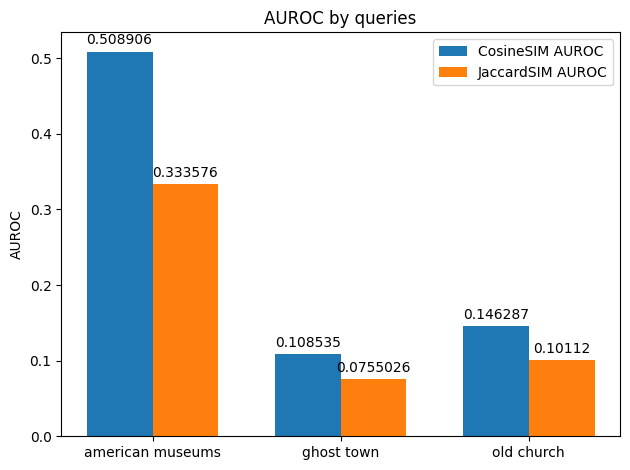

In [102]:
labels = ['american museums', 'ghost town', 'old church']

x = np.arange(len(labels))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cosine_scores, width, label='CosineSIM AUROC')
rects2 = ax.bar(x + width/2, jaccard_scores, width, label='JaccardSIM AUROC')

ax.set_ylabel('AUROC')
ax.set_title('AUROC by queries')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

As we can see our scores as classifiers perform below chance level when defining some relevance criteria. This may have many reasons, such as the semantic consistency between the columns of the dataset or the choice of the relevance feature. In any case the cosine similarity over the vectorized documents behaves way better than the jaccard similarity over the tags sets, so our new score surely needs some tuning deepening the features of the dataset.

# 4. Visualizing the most relevant places

In [25]:
df2 = engine.new_score_jaccard('historical castle', mostPopularPlaces, vocabulary, inverted_index, 10) 
df = pd.merge(df2,mostPopularPlaces, on='placeName')

#Taking only columns we are interested in
df = df[['placeName','numPeopleVisited','numPeopleWant','placeAddress','placeAlt','placeLong','newScore']]

In [26]:
#Taking out Country and address
df['Country'] = df.placeAddress.apply(lambda ad: locationtagger.find_locations(text = ad).countries)
df['Address'] = df.placeAddress.apply(lambda ad: ad.split(',')[0])
df['City'] = df.placeAddress.apply(lambda ad: locationtagger.find_locations(text = ad).cities)

In [27]:
#Converting Lat and Long in float
df['placeAlt']=df.placeAlt.apply(lambda p: float(p))
df['placeLong']=df.placeLong.apply(lambda p: float(p))

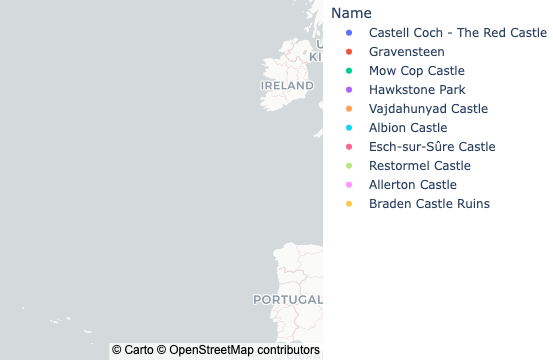

In [28]:
fig = px.scatter_mapbox(df, lat="placeAlt", lon="placeLong",
                        hover_name="placeName", 
                        hover_data=["placeName", "Address",'Country', "numPeopleVisited","City"],
                        color="placeName",
                        color_continuous_scale=px.colors.sequential.Blackbody,
                        zoom=3, 
                        height=300,
                        size_max=15,
                        labels={'placeAlt':'Latitude','placeLong':'Longitude','placeName':'Name','numPeopleVisited':'Number of people who visited','placeZone':'City'})
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

_________________________________________________

____________________________

# Command line

In order to check if the command line in the bash works properly

In [5]:
df_out = pd.read_csv(os.getcwd()+'/stuff/final_dataset.csv', usecols=['2', '3', '7'])
df_out = df_out.rename(columns={'2': 'numPeopleVisited', '3': 'numPeopleWant', '7': 'placeAddress'})
countries = ['Italy', 'Spain', 'France', 'England', 'United States']

for country in countries :
    n_places = len(df_out[df_out['placeAddress'].str.contains(country) == True])
    print("Country : ",country)
    print("Number of places that can be found in "+country+" : "+str(n_places))
    print("Average visit of the places of "+country+" : "+str(np.round(sum(df_out[df_out['placeAddress'].str.contains(country) == True].numPeopleVisited)/n_places,3)))
    print("People that want to visit the places of "+country+" : "+str('{:,}'.format(np.round(sum(df_out[df_out['placeAddress'].str.contains(country) == True].numPeopleWant,3)))))
    print('')

Country :  Italy
Number of places that can be found in Italy : 210
Average visit of the places of Italy : 383.005
People that want to visit the places of Italy : 182,300

Country :  Spain
Number of places that can be found in Spain : 91
Average visit of the places of Spain : 448.099
People that want to visit the places of Spain : 71,215

Country :  France
Number of places that can be found in France : 206
Average visit of the places of France : 424.898
People that want to visit the places of France : 204,662

Country :  England
Number of places that can be found in England : 365
Average visit of the places of England : 474.956
People that want to visit the places of England : 387,032

Country :  United States
Number of places that can be found in United States : 4616
Average visit of the places of United States : 436.025
People that want to visit the places of United States : 4,335,470



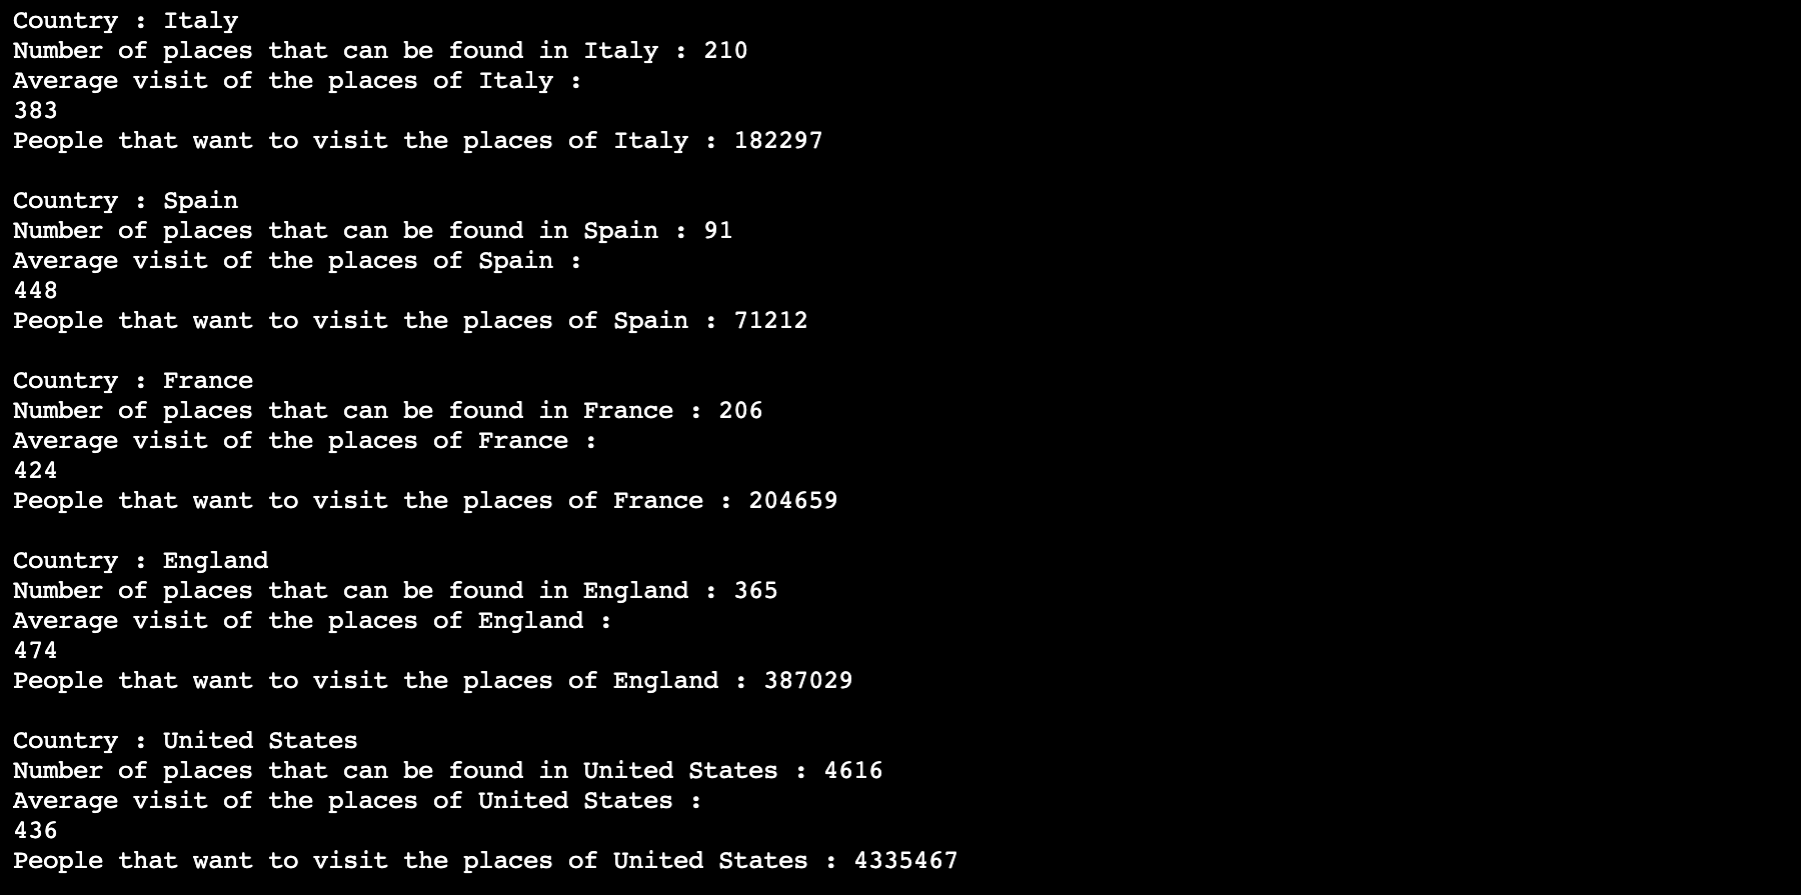

In [16]:
from IPython.display import Image

Image(filename='stuff/CommandLine_result.png') 

# Theoretical question

In [1]:
from functools import reduce
import random as rdm
import time
import matplotlib.pyplot as plt

First of all we want to define some useful subroutines to substitute built-ins methods with ones defined from scratch.

In [2]:
def maxer(arr:list)->int:
    M = 0
    for i in arr:
        if i > M:
            M = i
    return M

def miner(arr:list)->int:
    m = arr[0]
    for i in arr:
        if i < m:
            m = i
    return m

def meaner(arr:list) -> int:
    avger = lambda x:x/len(arr)
    summer = lambda a,b:a+b
    return reduce(summer,map(avger,arr))

def truncate(num, n):
    integer = int(num * (10**n))/(10**n)
    return float(integer)

In [3]:
applicants_info = open("stuff/ApplicantsInfo.txt", 'r')

lines = applicants_info.readlines()

n, m = list(map(int,lines[0].strip().split(' ')))
d = {}
for _ in range(1, n):
    name = ' '.join(lines[_].strip().split(' ')[0:2])
    scores = list(map(int,lines[_].strip().split(' ')[2:]))
    d[name] = round(meaner(scores), 2)

In [4]:
#Initializing lists for grades and students
l_students = []
l_grades = []

#build list for student names and corresponfìding grades average
for key in d:
    l_students.append(key)
    l_grades.append(d[key])

In order to solve the problem we are dealing with in TQ1, we are going to use three different sorting algorithms: **Bubble sort**, **Dynamic Insertion Sort** and **Merge Sort**

#### *1. Try solving the problem mentioned above using three different sorting algorithms*.

##### **Bubble sort**

In [107]:
l_grades1=l_grades
l_students1=l_students

In [108]:
def bubbleSort(grades, students):
    n = len(grades)
    swap = False
    
    for i in range(n-1):
        for j in range(0, n-i-1):
            if grades[j] > grades[j + 1]:                                       #we swap if the element found is greater than the next element
                swap = True
                grades[j], grades[j + 1] = grades[j + 1], grades[j]
                students[j], students[j + 1] = students[j + 1], students[j]
         
        if not swap:                                                            #the array is sorted
            return

In [109]:
# get the start time
st = time.time()

bubbleSort(l_grades1,l_students1)

# get the end time
et = time.time()

ex_time_bubble_sort= et - st

In [110]:
print('The running time of the Bubble Sort Algorithm is ',ex_time_bubble_sort)

The running time of the Bubble Sort Algorithm is  215.36831188201904


In [111]:
for tuple in list(zip(l_grades,l_students))[::-1]:
        new_line = str(tuple[0]) + " " + str(tuple[1])
        print(new_line)

24.49 Emily Crispin
24.49 Patricia Witten
24.45 Doreen Richmond
24.44 David Niederberger
24.44 Keisha Keene
24.44 Steven Boston
24.42 Melody Sanchez
24.42 Marvin Ramirez
24.42 John Johnson
24.41 Ida Mccabe
24.41 Edith Lehtonen
24.41 Joshua Reece
24.41 Luisa Young
24.41 Manuel Sullinger
24.4 Violet Paulino
24.4 Particia Mirabal
24.4 Cara Baird
24.4 Betty Kubiak
24.4 Mattie Salinas
24.39 Amy Walker
24.39 Marie Wall
24.39 Jeffrey Johnson
24.39 Kelsey Mcneill
24.39 Kathleen Whaley
24.39 Latoya Stemp
24.39 Harry Lupu
24.39 Richard Parker
24.38 Josephine Young
24.38 Rose Mcpeak
24.38 Desiree Paul
24.38 Olive Sacco
24.38 Jackson Klopfer
24.38 Daryl Singer
24.38 Norma Smith
24.38 Jeramy Galicia
24.37 Irvin Johnson
24.37 Ruth Heimsness
24.37 David Kerns
24.37 Tanesha Beard
24.37 Khalilah Hensley
24.37 Rhonda Bennett
24.37 Wilson Senske
24.37 Juan Gonzalez
24.37 Kyle Carlson
24.37 David Yang
24.37 Edward Corella
24.37 Robert Rector
24.37 Nancy Leonard
24.37 James Pal
24.36 Melissa Zuniga
24.36 M

The full output can be seen in the **TQ_output.txt** written by the next code block. 

In [112]:
with open('stuff/TQ_output.txt', 'w+') as new_file:
    for tuple in list(zip(l_grades,l_students))[::-1]:
        new_line = str(tuple[0]) + " " + str(tuple[1]) + '\n'
        new_file.write(new_line)

##### **Merge Sort**

In [5]:
def mergeSort(grades,students):
    if len(grades) > 1:
 
        #middle of array
        mid = len(grades)//2
 
        #splitting the right side
        left_g = grades[:mid] 
        left_s = students[:mid] 
 
        #splitting the left side
        right_g = grades[mid:]
        right_s = students[mid:]
 
        #sorting left side
        mergeSort(left_g, left_s)
 
        #sorting right side
        mergeSort(right_g, right_s)
 
        i = j = k = 0
 
        #copy arrays to temp arrays left[] and right[]
        while i < len(left_g) and j < len(right_g):
            if left_g[i] <= right_g[j]:
                grades[k] = left_g[i]
                students[k] = left_s[i]
                i += 1
            else:
                grades[k] = right_g[j]
                students[k] = right_s[j]
                j += 1
            k += 1
 
        #check if any element was left
        while i < len(left_g):
            grades[k] = left_g[i]
            students[k] = left_s[i]
            i += 1
            k += 1
 
        while j < len(right_g):
            grades[k] = right_g[j]
            students[k] = right_s[j]
            j += 1
            k += 1

In [6]:
l_grades2=l_grades
l_students2=l_students

In [115]:
# get the start time
st = time.time()

mergeSort(l_grades2,l_students2)

# get the end time
et = time.time()

ex_time_merge_sort= et - st

In [116]:
print('The running time of the Merge Sort Algorithm is ',ex_time_merge_sort)

The running time of the Merge Sort Algorithm is  0.16273140907287598


In [117]:
for tuple in list(zip(l_students2,l_grades2))[::-1]:
    print(tuple[0] + " " + str(tuple[1]))

Emily Crispin 24.49
Patricia Witten 24.49
Doreen Richmond 24.45
David Niederberger 24.44
Keisha Keene 24.44
Steven Boston 24.44
Melody Sanchez 24.42
Marvin Ramirez 24.42
John Johnson 24.42
Ida Mccabe 24.41
Edith Lehtonen 24.41
Joshua Reece 24.41
Luisa Young 24.41
Manuel Sullinger 24.41
Violet Paulino 24.4
Particia Mirabal 24.4
Cara Baird 24.4
Betty Kubiak 24.4
Mattie Salinas 24.4
Amy Walker 24.39
Marie Wall 24.39
Jeffrey Johnson 24.39
Kelsey Mcneill 24.39
Kathleen Whaley 24.39
Latoya Stemp 24.39
Harry Lupu 24.39
Richard Parker 24.39
Josephine Young 24.38
Rose Mcpeak 24.38
Desiree Paul 24.38
Olive Sacco 24.38
Jackson Klopfer 24.38
Daryl Singer 24.38
Norma Smith 24.38
Jeramy Galicia 24.38
Irvin Johnson 24.37
Ruth Heimsness 24.37
David Kerns 24.37
Tanesha Beard 24.37
Khalilah Hensley 24.37
Rhonda Bennett 24.37
Wilson Senske 24.37
Juan Gonzalez 24.37
Kyle Carlson 24.37
David Yang 24.37
Edward Corella 24.37
Robert Rector 24.37
Nancy Leonard 24.37
James Pal 24.37
Melissa Zuniga 24.36
Macie M

##### **Quick sort**

In [118]:
l_grades3=l_grades
l_students3=l_students

# Creating a list with student and their grade
stud_grad=list(zip(l_students3,l_grades3))

In [119]:
def par(items, low, high):
    
    #Choose the rightmost element
    pivot1 = items[high][1] # grades
    pivot2 = items[high][0] # names
    
    i = low - 1 # Pointer
    for j in range(low, high):
        if items[j][1] > pivot1: 
            i = i + 1 # increasing the pointer
            (items[i], items[j]) = (items[j], items[i]) # swap the element at i with element at j
        elif items[j][1] == pivot1:
            if items[j][0] < pivot2:
                i = i + 1 #increasing the pointer
                (items[i], items[j]) = (items[j], items[i]) # ...swap the element at i with element at j

    # Swap the pivot element with the greater element specified by i
    (items[i + 1], items[high]) = (items[high], items[i + 1])
  
    # Return the position from where partition is done
    return i + 1

def quickSort(items, low, high):
    if low < high:

        pi = par(items, low, high)
  
        quickSort(items, low, pi - 1)  # Recursive call on the left of pivot

        quickSort(items, pi + 1, high) # Recursive call on the right of pivot

In [120]:
# get the start time
st = time.time()

quickSort(stud_grad,0,len(stud_grad)-1)

# get the end time
et = time.time()

ex_time_quick_sort= et - st

In [121]:
print('The running time of the Quick Sort Algorithm is ',ex_time_quick_sort)

The running time of the Quick Sort Algorithm is  1.6785998344421387


In [122]:
for tuple in stud_grad:
    print(tuple[0] + " " + str(tuple[1]))

Emily Crispin 24.49
Patricia Witten 24.49
Doreen Richmond 24.45
David Niederberger 24.44
Keisha Keene 24.44
Steven Boston 24.44
John Johnson 24.42
Marvin Ramirez 24.42
Melody Sanchez 24.42
Edith Lehtonen 24.41
Ida Mccabe 24.41
Joshua Reece 24.41
Luisa Young 24.41
Manuel Sullinger 24.41
Betty Kubiak 24.4
Cara Baird 24.4
Mattie Salinas 24.4
Particia Mirabal 24.4
Violet Paulino 24.4
Amy Walker 24.39
Harry Lupu 24.39
Jeffrey Johnson 24.39
Kathleen Whaley 24.39
Kelsey Mcneill 24.39
Latoya Stemp 24.39
Marie Wall 24.39
Richard Parker 24.39
Daryl Singer 24.38
Desiree Paul 24.38
Jackson Klopfer 24.38
Jeramy Galicia 24.38
Josephine Young 24.38
Norma Smith 24.38
Olive Sacco 24.38
Rose Mcpeak 24.38
David Kerns 24.37
David Yang 24.37
Edward Corella 24.37
Irvin Johnson 24.37
James Pal 24.37
Juan Gonzalez 24.37
Khalilah Hensley 24.37
Kyle Carlson 24.37
Nancy Leonard 24.37
Rhonda Bennett 24.37
Robert Rector 24.37
Ruth Heimsness 24.37
Tanesha Beard 24.37
Wilson Senske 24.37
Aleisha Witte 24.36
Barbara 

#### *2. What is the time complexity of each algorithm you have used?*

The **Bubble Sort Algorithm** has the fastest best case complexity of $O(n)$ if the array is already sorted. In the worst case scenario we have got both the internal and external loop are going to iterate times each, for a total time complexity of $O$($n^2$).

The **Merge Sort Algorithm** has the same complexity for best, average and worst case, which is always $O(nlog(n)$.

The **Quick Sort Algorithm** has a complexity of $O(n^2)$. 
In the best case, **partition** is divided evenly every time, which means a complexity of $O(nlog(n))$.

The other sections (getting the data, printing the output) of the algorithm are linear in the dimension of the input, so the choice over the sorting algorithm dominates. 

#### *3. Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.*

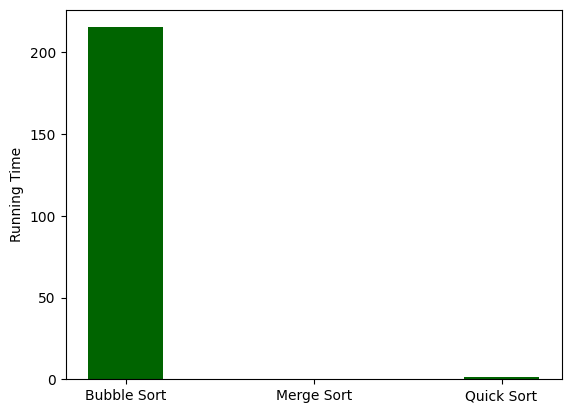

In [123]:
# creating the bar plot

algorithms = ['Bubble Sort', 'Merge Sort', 'Quick Sort']
times = [ex_time_bubble_sort, ex_time_merge_sort, ex_time_quick_sort]

plt.bar(algorithms,times, color ='darkgreen',
        width = 0.4)
 

plt.ylabel("Running Time")
plt.show()

Let's focus on Merge Sort and Quick Sort, because as we can see the Bubble Sort is not efficient.

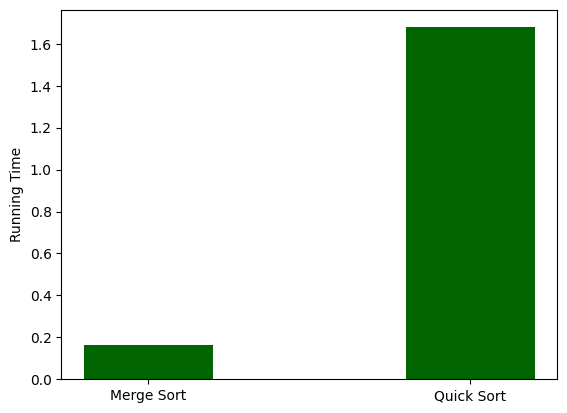

In [124]:
algorithms = ['Merge Sort', 'Quick Sort']
times = [ex_time_merge_sort, ex_time_quick_sort]

plt.bar(algorithms,times, color ='darkgreen',
        width = 0.4)
 

plt.ylabel("Running Time")
plt.show()

#### *4.What is the most optimal algorithm, in your opinion, and why?*

Merge Sort is the most optimal because its recursive implementation works on a binary tree that ensures the $nlog(n)$ complexity, which is below quadratic time complexity. This is clearly substantiated by the comparison about the running time.  

#### *5.Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.*

Since this MapReduce algorithm was performed on the EMR framework, here we're just importing the script as they were runned. 

First, we have to define a RDD object with the data.

In [ ]:
applicants_info = sc.textFile('s3://admhw3/ApplicantsInfo.txt')

We exclude the first line since it contains superfluous information.

In [ ]:
header = applicants_info.first()
applicants_info = applicants_info.filter(lambda row: row != header)

We now define useful subroutines.

In [ ]:
def extractName(row):
    return ' '.join(row.split(' ')[0:2])

def extractGrades(row):
    return [(extractName(row),grade) 
            for grade in list(map(int,row.split(' ')[2:1003]))]

And finally design and perform the actual MapReduce pipeline.

In [ ]:
applicants_info.flatMap(lambda row: extractGrades(row))\
.reduceByKey(lambda x,y: x+y)\
.map(lambda row: (row[0], row[1]/1000))\
.takeOrdered(10, lambda t,q:q[1]-t[1] or t[0]-q[0])